In [1]:
def import_data_from_drive(id):
  !wget --save-cookies cookies.txt 'https://docs.google.com/uc?export=download&id='{id} -O- \
  | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt && wget --content-disposition --load-cookies cookies.txt 'https://docs.google.com/uc?export=download&id='{id}'&confirm='$(<confirm.txt)

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pip install kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
%%capture
%cd /content/
!kaggle competitions download -c open-shopee-code-league-logistic

In [6]:
!unzip /content/delivery_orders_march.csv.zip

Archive:  /content/delivery_orders_march.csv.zip
  inflating: delivery_orders_march.csv  


## Data discription
* orderid- Each orderid represents a distinct transaction on Shopee
* pick - Pick Up Time, which is defined as the time (represented by epoch time) when the 3PL picks up the parcel and begins to process for delivery
* 1st_deliver_attempt - Time (represented by epoch time) when 3PL first attempts a delivery.
* 2nd_deliver_attempt - Time (represented by epoch time) when 3PL attempts a delivery again after the 1st attempt has failed. Orders which were successfully delivered the 1st time will not have a 2nd attempt
* buyeraddress - buyer's address (Destination)
* selleraddress- seller's address (Origin)

In [179]:
import pandas as pd
import numpy as np

data = pd.read_csv('/content/delivery_orders_march.csv')

In [180]:
from scipy import stats
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),5) 

    return summary
  
resumetable(data)

Dataset Shape: (3176313, 6)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,orderid,int64,0,3176313,2215676524,2219624609,2220979489,21.59892
1,pick,int64,0,236418,1583138397,1583309968,1583306434,16.11143
2,1st_deliver_attempt,float64,0,876961,1.58338e+09,1.58346e+09,1.58346e+09,19.36947
3,2nd_deliver_attempt,float64,1819311,529216,NaN,1.5838e+09,NaN,17.83449
4,buyeraddress,object,0,3176313,"Baging ldl BUENAVISTA,PATAG.CAGAYAN Buagsong,c...",coloma's quzom CASANAS Site1 Masiyan 533A Stol...,"21-O LumangDaan,Capitangan,Abucay,Bataan .Bign...",21.59892
5,selleraddress,object,0,3176313,Pantranco vill. 417 Warehouse# katipunan 532 (...,"BLDG 210A Moras C42B 2B16,168 church) Complex ...","#66 150-C, DRIVE, Milagros Joe socorro Metro M...",21.59892


In [181]:
data.columns

Index(['orderid', 'pick', '1st_deliver_attempt', '2nd_deliver_attempt',
       'buyeraddress', 'selleraddress'],
      dtype='object')

## SLA matrix

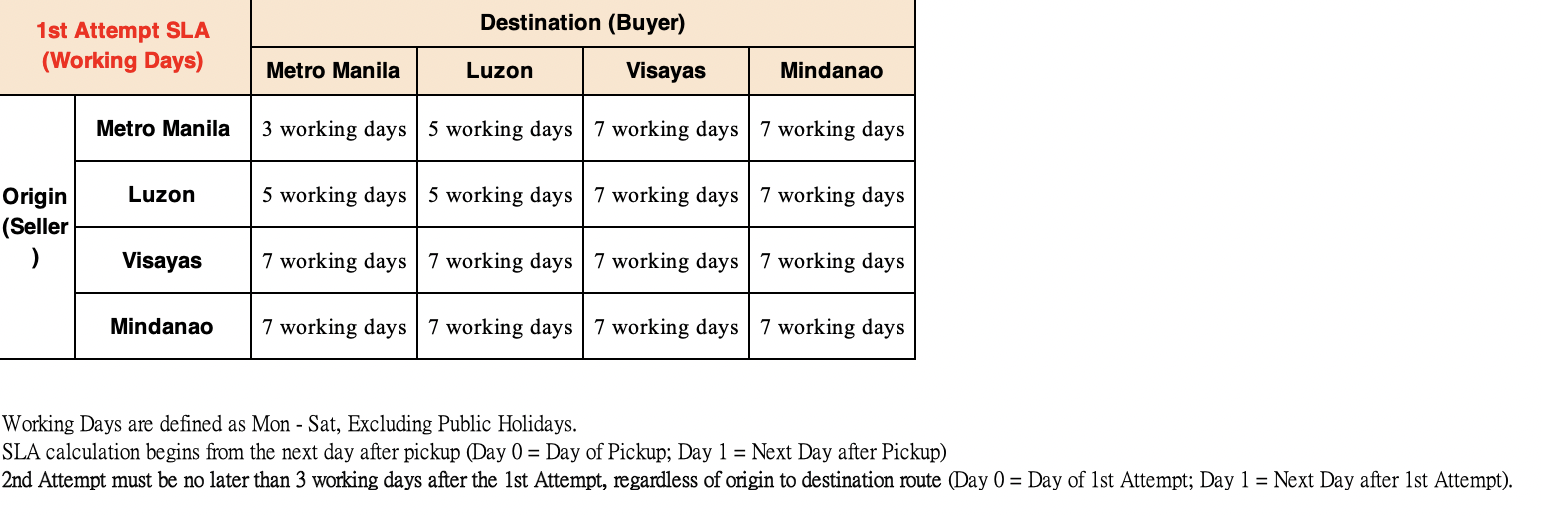

## Step 1: BusDay Count

In [182]:
data['pick'] = pd.to_datetime(data['pick'], unit='s')
data['1st_deliver_attempt'] = pd.to_datetime(data['1st_deliver_attempt'],  unit='s')
data['2nd_deliver_attempt'] = pd.to_datetime(data['2nd_deliver_attempt'],  unit='s')

In [183]:
data.head(5)

,orderid,pick,1st_deliver_attempt,2nd_deliver_attempt,buyeraddress,selleraddress
0,2215676524,2020-03-02 08:39:57,2020-03-05 05:09:18,NaT,"Baging ldl BUENAVISTA,PATAG.CAGAYAN Buagsong,c...",Pantranco vill. 417 Warehouse# katipunan 532 (...
1,2219624609,2020-03-04 08:19:28,2020-03-06 02:53:56,2020-03-10 00:02:56,coloma's quzom CASANAS Site1 Masiyan 533A Stol...,"BLDG 210A Moras C42B 2B16,168 church) Complex ..."
2,2220979489,2020-03-04 07:20:34,2020-03-06 01:56:19,NaT,"21-O LumangDaan,Capitangan,Abucay,Bataan .Bign...","#66 150-C, DRIVE, Milagros Joe socorro Metro M..."
3,2221066352,2020-03-05 14:36:56,2020-03-07 04:45:41,NaT,"616Espiritu MARTINVILLE,MANUYO #5paraiso kengi...","999maII 201,26 Villaruel Barretto gen.t number..."
4,2222478803,2020-03-04 10:38:25,2020-03-06 07:41:40,NaT,L042 Summerbreezee1 L2(Balanay analyn Lot760 C...,G66MANILA Hiyas Fitness MAYSILO magdiwang Lt.4...


In [184]:
#Time Zone
!date +"%Z %z"

UTC +0000


In [185]:
#All time formats are stored in epoch time based on Local Time (GMT+8).
data['pick'] = pd.to_datetime(data['pick'], format='%Y-%m-%d')+pd.Timedelta('08:00:00')
data['1st_deliver_attempt'] = pd.to_datetime(data['1st_deliver_attempt'], format='%Y-%m-%d')+pd.Timedelta('08:00:00')
data['2nd_deliver_attempt'] = pd.to_datetime(data['2nd_deliver_attempt'], format='%Y-%m-%d')+pd.Timedelta('08:00:00')


In [186]:
resumetable(data)

Dataset Shape: (3176313, 6)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,orderid,int64,0,3176313,2215676524,2219624609,2220979489,21.59892
1,pick,datetime64[ns],0,236418,2020-03-02 16:39:57,2020-03-04 16:19:28,2020-03-04 15:20:34,16.11143
2,1st_deliver_attempt,datetime64[ns],0,876961,2020-03-05 13:09:18,2020-03-06 10:53:56,2020-03-06 09:56:19,19.36947
3,2nd_deliver_attempt,datetime64[ns],1819311,529216,NaT,2020-03-10 08:02:56,NaT,17.83449
4,buyeraddress,object,0,3176313,"Baging ldl BUENAVISTA,PATAG.CAGAYAN Buagsong,c...",coloma's quzom CASANAS Site1 Masiyan 533A Stol...,"21-O LumangDaan,Capitangan,Abucay,Bataan .Bign...",21.59892
5,selleraddress,object,0,3176313,Pantranco vill. 417 Warehouse# katipunan 532 (...,"BLDG 210A Moras C42B 2B16,168 church) Complex ...","#66 150-C, DRIVE, Milagros Joe socorro Metro M...",21.59892


In [187]:
#第二次如果是空值，代表第一次就送成功
#最後應該是要找第二次-第一次時間超過幾天的，所以ＮＡ塞負數讓他減出來負的，就不會貼到
data.loc[data['2nd_deliver_attempt'].isna(),'2nd_deliver_attempt']=pd.Timestamp('1991-01-01')

In [188]:
busday_cnt_cond1 = np.busday_count(
    data['pick'].values.astype('datetime64[D]'),
    data['1st_deliver_attempt'].values.astype('datetime64[D]'),
    weekmask=[1,1,1,1,1,1,0],
    holidays = ['2020-03-08',
               '2020-03-25',
               '2020-03-30',
               '2020-03-31']
)

In [189]:
busday_cnt_cond2 = np.busday_count(
    data['1st_deliver_attempt'].values.astype('datetime64[D]'),
    data['2nd_deliver_attempt'].values.astype('datetime64[D]'),
    weekmask=[1,1,1,1,1,1,0],
    holidays = ['2020-03-08',
               '2020-03-25',
               '2020-03-30',
               '2020-03-31']
)

In [190]:
data['busday_cnt_cond1'] = busday_cnt_cond1
data['busday_cnt_cond2'] = busday_cnt_cond2

In [191]:
data.head(3)

,orderid,pick,1st_deliver_attempt,2nd_deliver_attempt,buyeraddress,selleraddress,busday_cnt_cond1,busday_cnt_cond2
0,2215676524,2020-03-02 16:39:57,2020-03-05 13:09:18,1991-01-01 00:00:00,"Baging ldl BUENAVISTA,PATAG.CAGAYAN Buagsong,c...",Pantranco vill. 417 Warehouse# katipunan 532 (...,3,-9134
1,2219624609,2020-03-04 16:19:28,2020-03-06 10:53:56,2020-03-10 08:02:56,coloma's quzom CASANAS Site1 Masiyan 533A Stol...,"BLDG 210A Moras C42B 2B16,168 church) Complex ...",2,3
2,2220979489,2020-03-04 15:20:34,2020-03-06 09:56:19,1991-01-01 00:00:00,"21-O LumangDaan,Capitangan,Abucay,Bataan .Bign...","#66 150-C, DRIVE, Milagros Joe socorro Metro M...",2,-9135


## Step 2: Extract destination info
* Metro Manila
* Luzon
* Visayas
* Mindanao


In [192]:
#全部小寫
data['buyeraddress'][4]

'L042 Summerbreezee1 L2(Balanay analyn Lot760 Cluster3-2T seppina UPPERG/L luzon'

In [193]:
data['buyeraddress'][6]

'Ka-insong stockholme Lhuilier, polanco. malen SHOP)) Metro Manila'

In [194]:
data['buyeraddress'][6].lower()

'ka-insong stockholme lhuilier, polanco. malen shop)) metro manila'

In [195]:
data['buyeraddress'] = data['buyeraddress'].apply(lambda x: x.lower())
data['selleraddress'] = data['selleraddress'].apply(lambda x: x.lower())

In [196]:
data['buyeraddress'][6]

'ka-insong stockholme lhuilier, polanco. malen shop)) metro manila'

In [197]:
len(data)

3176313

In [198]:
data['buyeraddress'][0]

'baging ldl buenavista,patag.cagayan buagsong,cordova,cebu mt.vernon buolding, habagat lordman natl metro manila'

In [199]:
buyeraddress_city = []

for i in  data['buyeraddress']:
  cnt = 0;
  if 'manila' in i.split()[-1] : 
    buyeraddress_city.append('metro manila')
    cnt+=1
  if 'luzon' in i.split()[-1] : 
    buyeraddress_city.append('luzon')
    cnt+=1
  if 'visayas' in i.split()[-1] : 
    buyeraddress_city.append('visayas')
    cnt+=1
  if 'mindanao' in i.split()[-1]: 
    buyeraddress_city.append('mindanao')
    cnt+=1
  if cnt>2:
    print(i)

In [200]:
len(buyeraddress_city)

3176313

In [201]:
selleraddress_city = []

for i in  data['selleraddress']:
  cnt = 0;
  if 'manila' in i.split()[-1] : 
    selleraddress_city.append('metro manila')
    cnt+=1
  elif 'luzon' in i.split()[-1] : 
    selleraddress_city.append('luzon')
    cnt+=1
  elif 'visayas' in i.split()[-1] : 
    selleraddress_city.append('visayas')
    cnt+=1
  elif 'mindanao' in i.split()[-1]: 
    selleraddress_city.append('mindanao')
    cnt+=1
  if cnt>2:
    print(i)

In [202]:
len(selleraddress_city)

3176313

In [203]:
data['buyeraddress_city'] = buyeraddress_city
data['selleraddress_city'] = selleraddress_city

In [204]:
data.head(3)

,orderid,pick,1st_deliver_attempt,2nd_deliver_attempt,buyeraddress,selleraddress,busday_cnt_cond1,busday_cnt_cond2,buyeraddress_city,selleraddress_city
0,2215676524,2020-03-02 16:39:57,2020-03-05 13:09:18,1991-01-01 00:00:00,"baging ldl buenavista,patag.cagayan buagsong,c...",pantranco vill. 417 warehouse# katipunan 532 (...,3,-9134,metro manila,metro manila
1,2219624609,2020-03-04 16:19:28,2020-03-06 10:53:56,2020-03-10 08:02:56,coloma's quzom casanas site1 masiyan 533a stol...,"bldg 210a moras c42b 2b16,168 church) complex ...",2,3,metro manila,metro manila
2,2220979489,2020-03-04 15:20:34,2020-03-06 09:56:19,1991-01-01 00:00:00,"21-o lumangdaan,capitangan,abucay,bataan .bign...","#66 150-c, drive, milagros joe socorro metro m...",2,-9135,metro manila,metro manila


## Filter

In [205]:
SLA_matrix = pd.DataFrame({'buyeraddress_city':['metro manila','luzon','visayas','mindanao','metro manila','luzon','visayas','mindanao','metro manila','luzon','visayas','mindanao','metro manila','luzon','visayas','mindanao']})

In [206]:
SLA_matrix['selleraddress_city'] = ['metro manila','metro manila','metro manila','metro manila',
                                    'luzon','luzon','luzon','luzon',
                                    'visayas','visayas','visayas','visayas',
                                    'mindanao','mindanao','mindanao','mindanao']

In [207]:
SLA_matrix['nolate_date'] = [3,5,7,7,
                             5,5,7,7,
                             7,7,7,7,
                             7,7,7,7]

In [208]:
data = data.merge(SLA_matrix,on = ['buyeraddress_city','selleraddress_city'],how='left')

In [209]:
data.head(3)

,orderid,pick,1st_deliver_attempt,2nd_deliver_attempt,buyeraddress,selleraddress,busday_cnt_cond1,busday_cnt_cond2,buyeraddress_city,selleraddress_city,nolate_date
0,2215676524,2020-03-02 16:39:57,2020-03-05 13:09:18,1991-01-01 00:00:00,"baging ldl buenavista,patag.cagayan buagsong,c...",pantranco vill. 417 warehouse# katipunan 532 (...,3,-9134,metro manila,metro manila,3
1,2219624609,2020-03-04 16:19:28,2020-03-06 10:53:56,2020-03-10 08:02:56,coloma's quzom casanas site1 masiyan 533a stol...,"bldg 210a moras c42b 2b16,168 church) complex ...",2,3,metro manila,metro manila,3
2,2220979489,2020-03-04 15:20:34,2020-03-06 09:56:19,1991-01-01 00:00:00,"21-o lumangdaan,capitangan,abucay,bataan .bign...","#66 150-c, drive, milagros joe socorro metro m...",2,-9135,metro manila,metro manila,3


In [210]:
(data['busday_cnt_cond1']>data['nolate_date']).value_counts()

False    2734919
True      441394
dtype: int64

In [211]:
data['is_late'] = np.where((data['busday_cnt_cond1']>data['nolate_date']) | (data['busday_cnt_cond2']>3),1,0)

In [212]:
data.columns

Index(['orderid', 'pick', '1st_deliver_attempt', '2nd_deliver_attempt',
       'buyeraddress', 'selleraddress', 'busday_cnt_cond1', 'busday_cnt_cond2',
       'buyeraddress_city', 'selleraddress_city', 'nolate_date', 'is_late'],
      dtype='object')

In [213]:
submit = data[['orderid','is_late']]

In [214]:
submit.shape

(3176313, 2)

In [215]:
submit.to_csv('/content/submit.csv',index=False)

In [216]:
!kaggle competitions submit -c open-shopee-code-league-logistic -f /content/submit.csv -m "try_2021"

100% 41.2M/41.2M [00:00<00:00, 60.2MB/s]
Successfully submitted to [Open] Shopee Code League - Logistics

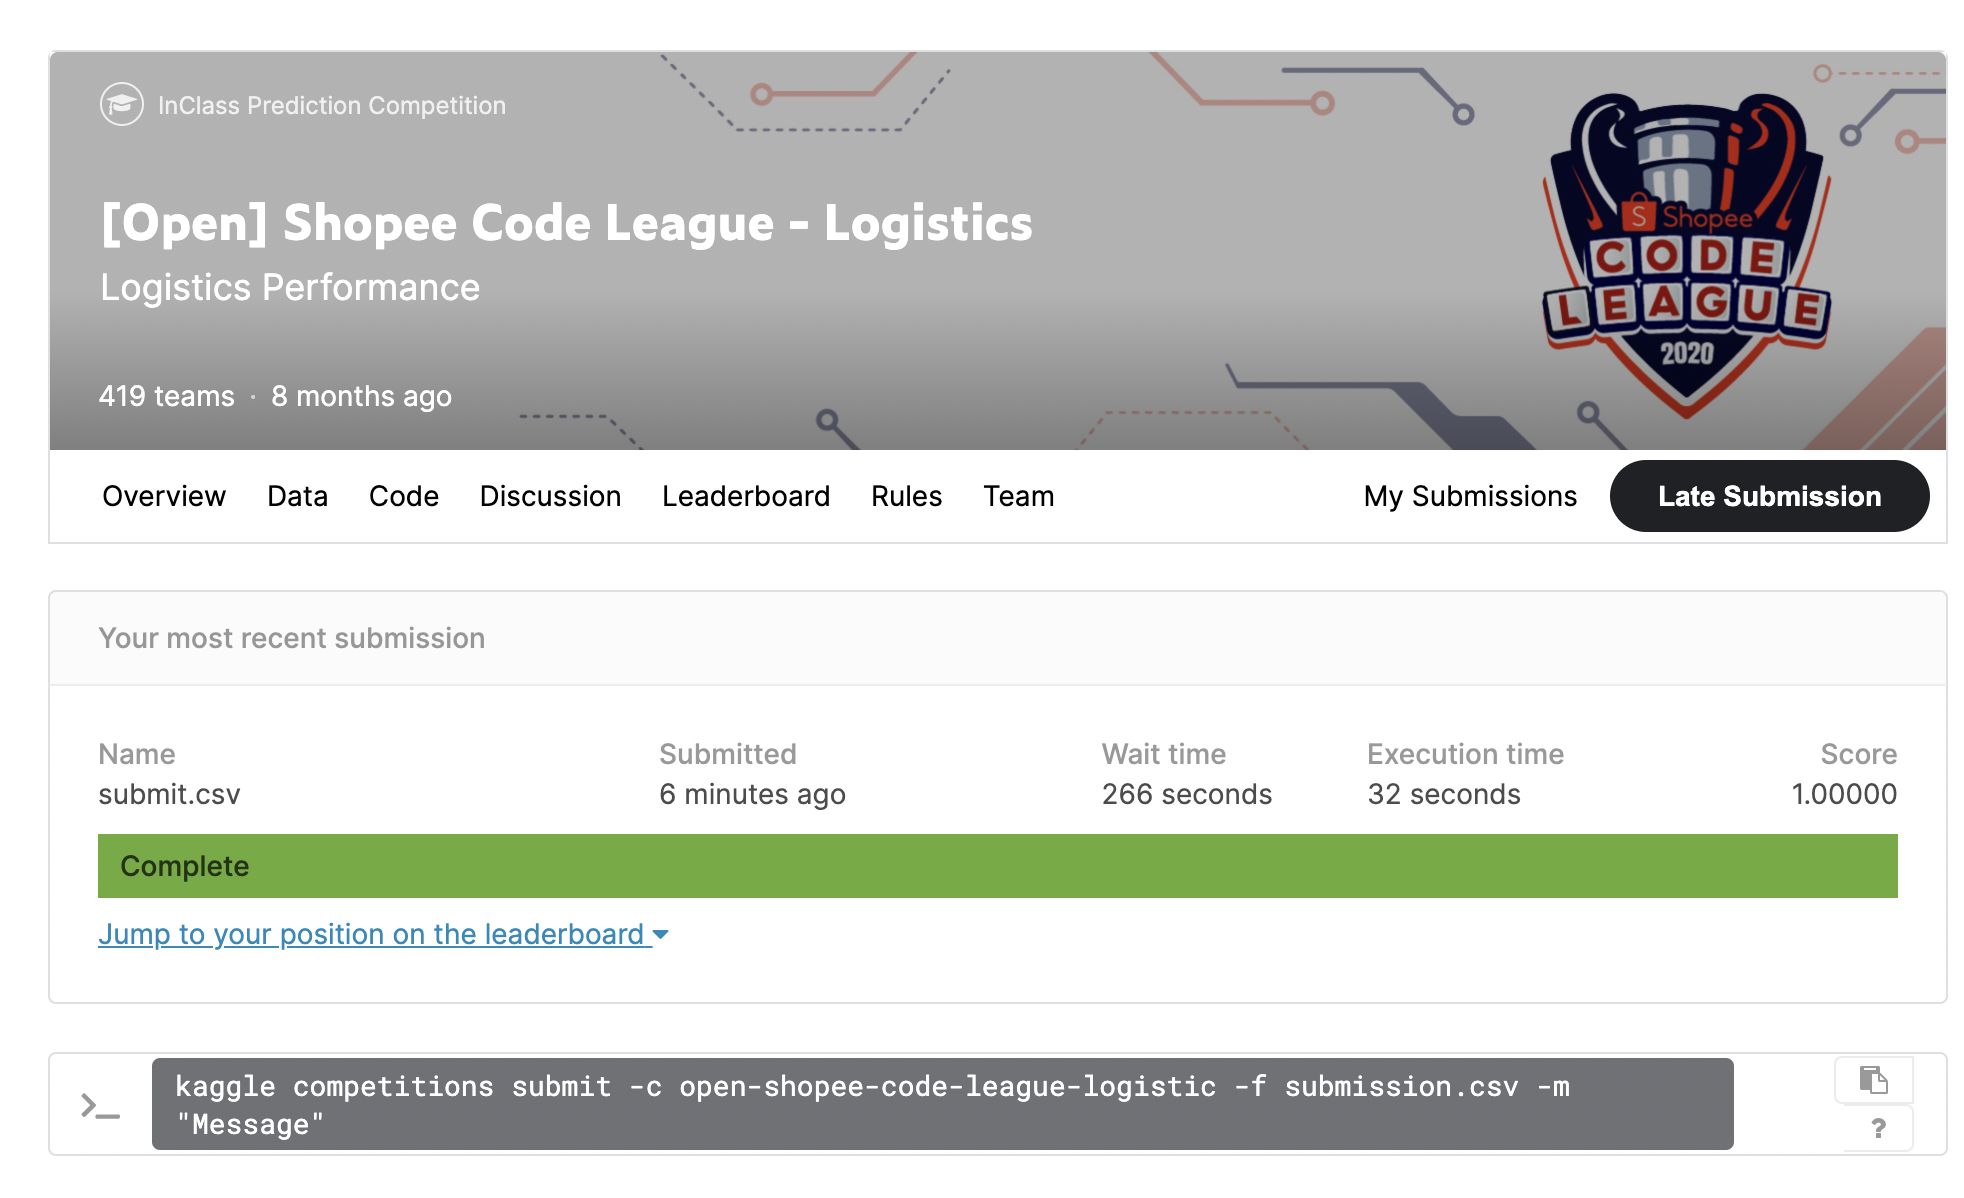